# N-grams analysis
Ngrams, like cloud of words, seeks to identify the most frequent sets of words, for example bigrams is the set of pairs of words in a corpus:
"This is an example text", has the following bigrams: "This is", "is an", "an example", "example text". We extend the term to n-grams when we talk about a combination of n
words.

In this notebook, we will utilzie CountVectorizer form sklearn.

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from tqdm import tqdm

import polars as pl
import sys
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

stopwords_en = ENGLISH_STOP_WORDS

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import config
from paths import Paths

channel_paths = Paths(channel_handle=config.channel_handle)

## Extract data from enriched file

**Note**: This notebook uses a column from the enriched dataset.

Here we are leveraging the lazy framework from the polars library. In this case, we load all datasets lazily, select the desired column and stream the results into the model.


In [ ]:
ldf = pl.scan_parquet(channel_paths.list_enriched_files()).select('tokens_simple')
BATCH_SIZE = 100_000

def token_texts_gen():
    offset = 0
    while True:
        batch = ldf.slice(offset, BATCH_SIZE).collect(engine="streaming")
        if batch.height == 0:
            break
        for tokens in batch["tokens_simple"]:
            yield " ".join(tokens)
        offset += BATCH_SIZE

# bigrams and trigrams
vectorizer = CountVectorizer(ngram_range=(2, 3), analyzer="word", min_df=10, max_features=500_000)


Learning the vocabulary

In [ ]:
X = vectorizer.fit_transform(token_texts_gen())

Get the ngrams and the respective counts from the model

In [ ]:
ngrams = vectorizer.get_feature_names_out()
freqs = X.sum(axis=0).A1  # Convert to 1D array
ngram_freq = sorted(zip(ngrams, freqs), key=lambda x: -x[1]) # descending

We want to get rid of ngrams made only of stopwords: "this is", "I am", etc., pairs of words that don't add any value or any context to our data.

Once we filter the stopwords, we convert the ngrams to a polars dataframe, and add the identifier of the kind of ngram, length 2 if bigram or length 3 if trigram.

In [ ]:
# Filter stopword only ngrams
filtered = [
    (ngrams, count)
    for ngrams, count in ngram_freq
    if not all(word in stopwords_en for word in ngrams.split())
]

# Convert to polars dataframe
df_ngrams = pl.DataFrame({
    "ngram": [ngram for ngram, _ in filtered],
    "count": [int(count) for _, count in filtered],
})

# Add ngram identifier (length of ngram)
df_ngrams = df_ngrams.with_columns([
    pl.col("ngram").str.split(" ").list.len().alias("ngram_len")
])

### Save progress to parquet

We will save our ngrams to our results folder, in the case that they are needed later. In our case, we will do a cloud of words.

In [ ]:
# Save to parquet in the results folder
df_ngrams.write_parquet(os.path.join(channel_paths.results_dir, f'{config.channel_handle}_ngrams.parquet'), compression='zstd')

If you wish to continue the process at a later time, you may resume from this point.

In [ ]:
# Load from results forlder
df_ngrams = pl.read_parquet(os.path.join(channel_paths.results_dir, f'{config.channel_handle}_ngrams.parquet'))

# Cloud of Words - Ngrams

We will follow a similar process to the creation of the wordcloud for single words. By the use of the WordCloud library.

In [15]:
def make_word_cloud_from_freq(frequencies, **kwargs):
    wordcloud = WordCloud(**kwargs).generate_from_frequencies(frequencies)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

Custom colormap

In [7]:
colors = ["#FBBE00", "#E30050", "#E32E01", "#FFFFFF", "#FF7F50"]
background_color = "#0B0F33"
cmap = ListedColormap(colors)

params = dict(
    font_path = os.path.join('..', 'assets', 'Montserrat-Regular.ttf'),
    width = 1000,
    height = 1000,
    max_font_size = 150,
    max_words = 100,
    background_color = background_color,
    colormap = cmap,
    contour_width = 0
    )

Sepparate the dataset in two, one for bigrams and one for trigrams.

In [ ]:
df_bigrams = df_ngrams.filter(pl.col("ngram_len") == 2)
df_trigrams = df_ngrams.filter(pl.col("ngram_len") == 3)

# Convert to Python dicts {ngram: count}
bigram_freq = dict(zip(df_bigrams["ngram"], df_bigrams["count"]))
trigram_freq = dict(zip(df_trigrams["ngram"], df_trigrams["count"]))

## Cloud of words - bigrams

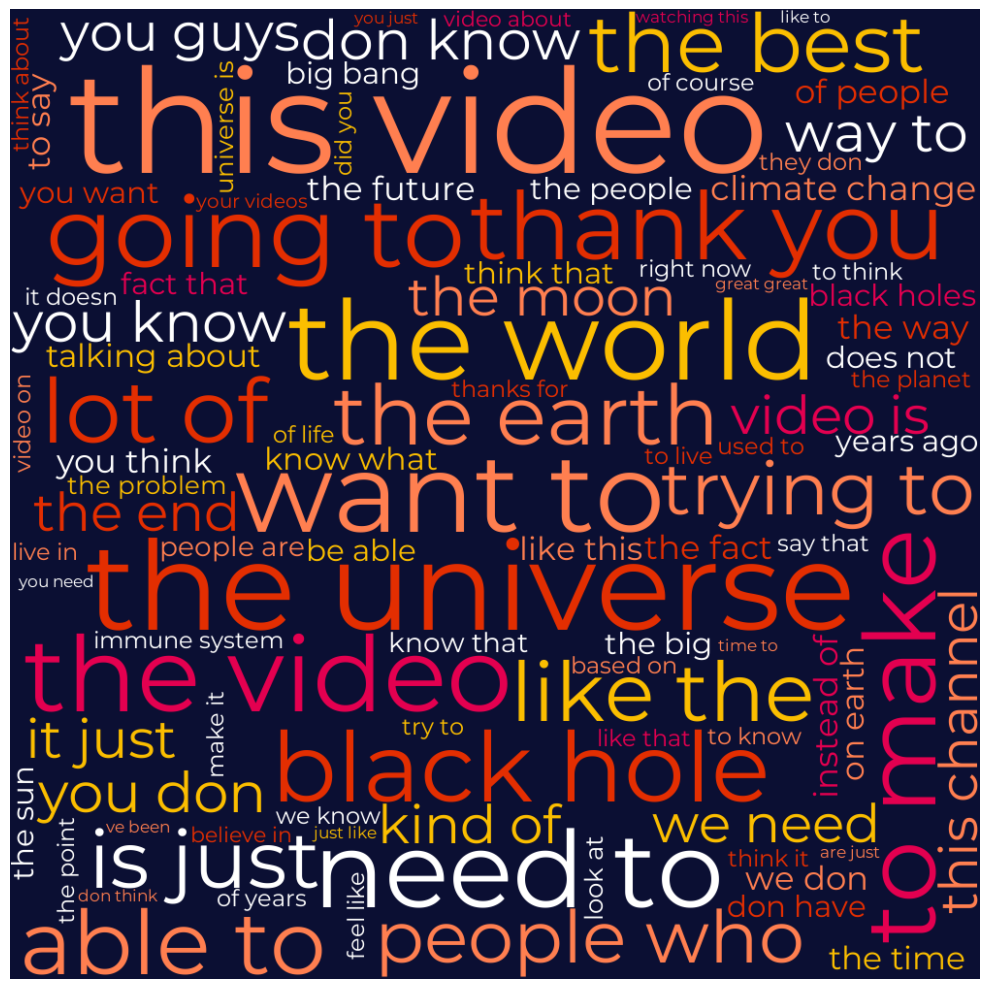

In [16]:
make_word_cloud_from_freq(bigram_freq, **params)


## Cloud of words - Trigrams

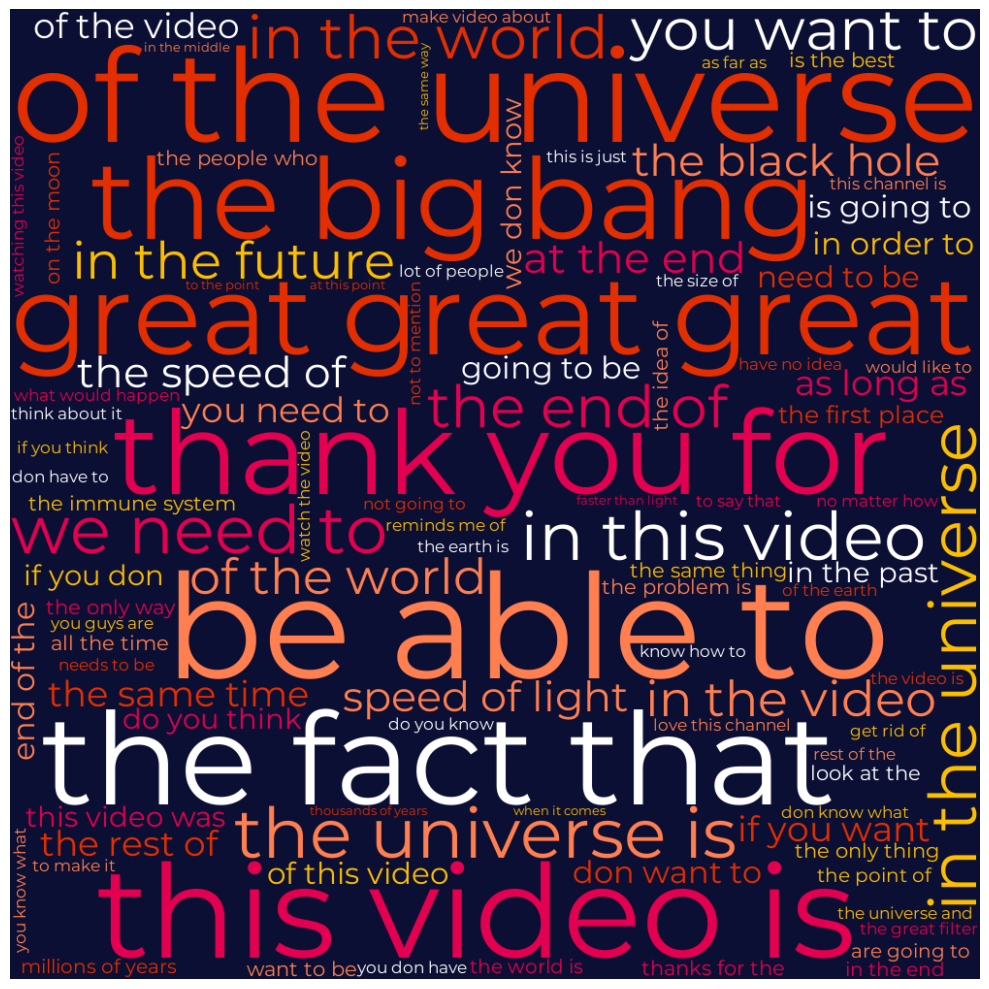

In [17]:
make_word_cloud_from_freq(trigram_freq, **params)